In [1]:
%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from EOS import NeutronStarEOS
from ode_system import *
from omars_little_helpers import create_r_mesh, plot_something
apr_eos = NeutronStarEOS('APR')

## 1) Initial conditions

In [2]:
# Define the domain for r
ri = 1e-15
rf = 2e6 # right below the expected radius to debug the code first

rho_c = 1e15
a_prime_initial = 0

boundary_conditions_func, a_initial, nu_initial, llambda_initial, rho_initial = create_boundary_conditions(eos_class=apr_eos,
    rho_c=rho_c,
    nu_c=1,
    lambda_c=0,
    a_c=-8.9088e-04,
    ri=ri
)
print(boundary_conditions_func)
print(f"a_initial= {a_initial:0.2e}" )
print(f"nu_initial = {nu_initial:0.2e}")
print(f"llambda_initial= {llambda_initial:0.2e}")
print(f"rho_initial:{rho_initial:0.2e}")

initial_conditions = [a_initial, a_prime_initial, nu_initial, llambda_initial, rho_initial]

<function create_boundary_conditions.<locals>.boundary_conditions at 0x10c882ca0>
a_initial= -8.91e-04
nu_initial = 1.00e+00
llambda_initial= 6.21e-43
rho_initial:1.00e+15


In [3]:
# the system need to be wrapped since solve_ivp expects the ode
# function to be only function of (independent, dependent) variables
def inside_ivp_wrapper(r, y):
    P = apr_eos.get_pressure(extrapolate=True)
    dPdRho = apr_eos.dP_dRho()
    return inside_ivp_system(r, y, P, dPdRho)

In [4]:
#Global variable to store the previous value of r
previous_rho = [None]  # Use a list to allow modification inside the event function

def stop_at_rho_negative(r, y):
    # Access the global variable
    global previous_rho
    rho = y[-1]

    # Check if the difference is less than the threshold
    if rho < 1e-8 :
        return 0  # Condition met, propose to stop integration
    else:
        return 1  # Condition not met, continue integration

# Make the event function terminal
stop_at_rho_negative.terminal = True

## 2) solve_ivp to get R

In [6]:
def solve_system(a_initial):
    global initial_conditions
    # Solve the ivp
    initial_conditions = [a_initial, a_prime_initial, nu_initial, llambda_initial, rho_initial]
    sol = solve_ivp(inside_ivp_wrapper, [ri,rf], initial_conditions, method='LSODA', events = stop_at_small_r_step)

    # Process the solution
    # Check if the solution is successful and process it
    if sol.success:
        print('Solution found!')
        print(sol.message)
    else:
        print("Solution was not successful.")
        print(sol.message)
    return sol
sol = solve_system(a_initial)

Solution found!
A termination event occurred.


In [7]:
r = sol.t[:-1]  # to avoid taking a negative density use [:-1]
a, a_prime, nu, llambda, rho= sol.y[:,:-1]

In [12]:
idx_outside = np.argmin(rho)
radius_ns = r[idx_outside]
#mass_ns = mass_values[idx_outside]
print(f"The star has radius = {radius_ns/1e5:0.4} km at density = {rho[idx_outside]:0.4} g/cm^(3)")

The star has radius = 11.43 km at density = 1.416 g/cm^(3)


In [40]:
def plot_something(x, y, y_label, x_label=r'$r(km)$', y_scale=None, debug=False):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x/1e5, y, color='blue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if debug:
        ax.set_xlim(1e-1, 2e2)
    else:
        ax.set_xscale('log')
    if y_scale == 'log':
        ax.set_yscale('log')
    ax.axvline(x=1e6/1e5, linestyle='--', color='grey', linewidth=0.4, zorder=-1)
    ax.axhline(y=0, linestyle='--', color='grey', linewidth=0.4, zorder=-1)
    ax.set_xlim(1e-4, x[-1]/1e5)
    plt.show()
    #plt.close(fig)

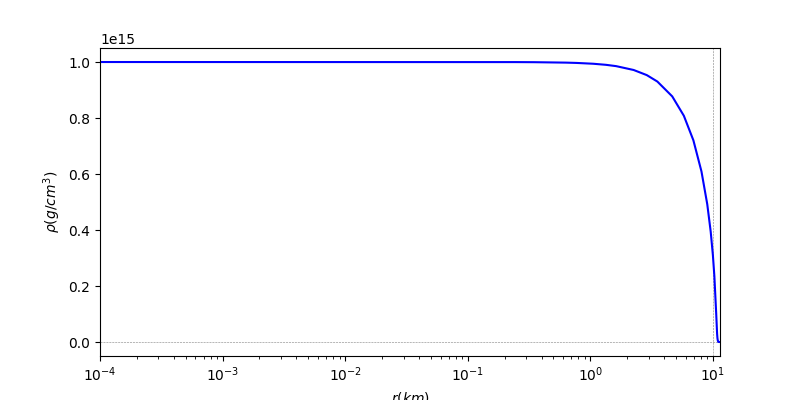

In [41]:
plot_something(r, rho, r"$\rho(g/cm^{3})$", x_label=r'$r(km)$')

# odeint method

In [8]:
from scipy.optimize import minimize

def optimization_target(a_initial):
    try:
        sol = solve_system(a_initial[0])
    except Exception as e:
        print(f"Error encountered within solve_system: {e}")
        return 0  # Return a high value to indicate failure
    # Access the derivative of A at the last point
    a_prime_at_rfar = sol.y[1, -1]  # Ensure this is the correct row for dA/dr
    # Objective: Minimize the square of the difference from desired condition (e.g., dA/dr at rfar = 0)
    return np.abs(a_prime_at_rfar - 0)

# Initial guess for A(0) as a scalar
a_initial_guess = -0.000356551  # Ensuring it's a scalar

# Use minimize to find the optimal A(0)
result = minimize(optimization_target, a_initial_guess)

if result.success:
    optimized_A0 = result.x[0]  # Extract the optimized A(0) value
    print(f"Optimized A(0): {optimized_A0}")
else:
    print("Optimization failed:", result.message)
